In [1]:
from model import *
from helpers import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Set up sensitivity tests

In [2]:
default_params = {
    "tau": 18,
    "W_LIP": 9
}

In [3]:
# runs the model for each value of a parameter
def sweep_param(param_name, values, default_params=default_params,
                verbose=True):
    results_all = []

    for val in values:
        if verbose:
            print(f"Running {param_name} = {val}")

        # Update parameters
        params = default_params.copy()
        params[param_name] = val

        # Run model and store results
        results = run_model(**params)
        results_all.append(results)

    return param_name, values, results_all

#### Plot formatting tools

In [4]:
import matplotlib.colors as colors

def get_colormap_and_norm(values, cmap_name='cividis'):
    values = np.array(values)
    vmin, vmax = np.min(values), np.max(values)
    cmap = plt.colormaps[cmap_name]
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return cmap, norm

In [5]:
from matplotlib.collections import LineCollection
from scipy.interpolate import make_interp_spline

# helper function to add a fitted line to a dot series

def add_fitted_line(ax, x, y,
                    cmap_name='cividis',
                    mode='segments',
                    color_mode='gradient',
                    alpha=1.0,
                    ):
    x = np.asarray(x)
    y = np.asarray(y)
    valid = np.isfinite(x) & np.isfinite(y)

    if np.sum(valid) < 2 or mode == 'none':
        return  # Not enough valid points or disabled

    x = x[valid]
    y = y[valid]
    colors = None
    if color_mode == 'gradient':
        cmap, norm = get_colormap_and_norm(x, cmap_name)
        colors = [cmap(norm(v)) for v in x]

    if mode == 'segments':
        segments = [[[x0, y0], [x1, y1]] for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
        if color_mode == 'gradient' and colors is not None:
            avg_colors = [tuple((np.array(c0) + np.array(c1)) / 2)
                          for c0, c1 in zip(colors[:-1], colors[1:])]
            lc = LineCollection(segments, colors=avg_colors, linewidths=1.5, alpha=alpha)
        else:
            lc = LineCollection(segments, colors='black', linewidths=1.5, alpha=alpha)
        ax.add_collection(lc)

    elif mode == 'spline':
        k = min(3, len(x) - 1)
        spline = make_interp_spline(x, y, k=k)
        x_smooth = np.linspace(min(x), max(x), 200)
        y_smooth = spline(x_smooth)

        if color_mode == 'gradient' and colors is not None:
            # generate colors along the spline
            cmap, norm = get_colormap_and_norm(x, cmap_name)
            colors_smooth = [cmap(norm(v)) for v in np.linspace(min(x), max(x), 200)]

            # create line segments from smoothed x/y
            points = np.array([x_smooth, y_smooth]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, colors=colors_smooth[:-1], linewidths=1.5, alpha=alpha)
            ax.add_collection(lc)
        else:
            ax.plot(x_smooth, y_smooth, color='black', alpha=alpha, linewidth=1.5)


In [6]:
# parameter descriptions/labels

def get_unit(param_name, param_info=param_info):
    raw_unit = param_info.get(param_name, {}).get('unit', '')
    if raw_unit == 'Examol/Myr':
        return 'Tmol/yr'
    return raw_unit or 'unitless'

def get_param_label(param_name, param_info=param_info):
    info = param_info.get(param_name, {'desc': param_name})
    desc = info['desc']
    unit = get_unit(param_name, param_info)
    return f"{desc} [{unit}]"

def get_legend_title(param_name, param_info=param_info):
    unit = get_unit(param_name, param_info)
    return f"{param_name} [{unit}]"

get_param_label('n'),get_legend_title('V_C')

('Silicate weathering feedback strength [unitless]', 'V_C [Tmol/yr]')

#### Analyze and plot durations

In [7]:
# extracts the first snowball duration from each result

def get_snowball_durations(results_all):
    snowball_durations = []

    for results in results_all:
        t = results["t"]
        snowball = results["snowball"]
        sb_starts, sb_ends, sb_durs, ig_durs = get_times(t, snowball)
        first_snowball = sb_durs[0] if sb_durs else np.nan
        snowball_durations.append(first_snowball)

    return snowball_durations

In [8]:
# plots snowball durations vs parameter values

def plot_snowball_durations_ax(ax, param_name, values,
                               snowball_durations,
                               cmap_name='cividis',color_dots=True,
                               line_mode='segments',line_color_mode='gradient',line_alpha=1,
                               ylim=(2,4)):
    if color_dots:
        cmap, norm = get_colormap_and_norm(values, cmap_name)
    
    values = np.array(values)
    durations = np.array(snowball_durations)
    
    for val, dur in zip(values, durations):
        color = cmap(norm(val)) if color_dots else 'k'
        ax.plot(val, dur, marker='o', color=color)
        
    add_fitted_line(ax, values, durations, cmap_name=cmap_name,
                    mode=line_mode, color_mode=line_color_mode, alpha=line_alpha)

    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlabel(get_param_label(param_name))
    ax.set_ylabel("First Snowball duration (Myr)")

In [9]:
# extracts interglacial durations and snowball start/end times

def get_interglacial_durations(results_all):
    interglacial_durations = []
    snowball_starts_all = []
    snowball_ends_all = []

    for results in results_all:
        t = results["t"]
        snowball = results["snowball"]
        sb_starts, sb_ends, sb_durs, ig_durs = get_times(t, snowball)
        snowball_starts_all.append(sb_starts)
        snowball_ends_all.append(sb_ends)
        interglacial_durations.append(ig_durs)

    return interglacial_durations, snowball_starts_all, snowball_ends_all

In [10]:
from scipy.interpolate import make_interp_spline

# plots interglacial durations as horizontal segments with spline fit through centers

def plot_interglacial_durations_ax(ax, param_name, values,
                                   interglacial_durations,
                                   snowball_starts_all,
                                   snowball_ends_all,
                                   highlight_vals=None,
                                   cmap_name='cividis',
                                   ylim=(0, 15)):

    # filter data if highlight_vals are specified
    if highlight_vals is not None:
        filtered = [
            (val, ig, sb_starts, sb_ends)
            for val, ig, sb_starts, sb_ends in zip(values, interglacial_durations, snowball_starts_all, snowball_ends_all)
            if val in highlight_vals
        ]
    else:
        filtered = list(zip(values, interglacial_durations, snowball_starts_all, snowball_ends_all))

    cmap, norm = get_colormap_and_norm(values, cmap_name)

    for val, ig_durs, sb_starts, sb_ends in filtered:
        color = cmap(norm(val))

        # Horizontal duration lines
        for i in range(len(ig_durs)):
            x0 = sb_ends[i]
            x1 = sb_starts[i + 1]
            y = ig_durs[i]
            ax.plot([x0, x1], [y, y], c=color)

        # Spline fit through midpoints
        if len(ig_durs) >= 2:
            midpoints = [(sb_ends[i] + sb_starts[i + 1]) / 2 for i in range(len(ig_durs))]
            x_smooth = np.linspace(min(midpoints), max(midpoints), 200)
            k = min(3, len(midpoints) - 1)
            spline = make_interp_spline(midpoints, ig_durs, k=k)
            y_smooth = spline(x_smooth)
            ax.plot(x_smooth, y_smooth, c=color, alpha=0.5)

        ax.plot([], [], color=color, label=f"{val}")

    ax.set_xlim(0, 60)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlabel("Time (Myr)")
    ax.set_ylabel("Interglacial durations (Myr)")
    ax.legend(title=get_legend_title(param_name), loc='best')

In [11]:
# Combined duration plot

def plot_durations(param_name, param_values,
                   snowball_durations,
                   interglacial_durations,
                   snowball_starts_all,
                   snowball_ends_all,
                   cmap_name='cividis',
                   color_dots=True,
                   line_mode='segments',
                   line_color_mode='gradient',
                   line_alpha=1,
                   highlight_vals=None,
                   snowball_ylim=(2,4),
                   interglacial_ylim=(-0.3,20.3)
                   ):
    
    fig, axs = plt.subplots(1, 2, figsize=(4.18 * 2, 2.54), constrained_layout=True)

    plot_snowball_durations_ax(axs[0], param_name, param_values, snowball_durations,
                               cmap_name=cmap_name,color_dots=color_dots,
                               line_mode=line_mode,line_color_mode=line_color_mode,line_alpha=line_alpha,
                               ylim=snowball_ylim)
    plot_interglacial_durations_ax(axs[1], param_name, param_values,
                                   interglacial_durations, snowball_starts_all, snowball_ends_all,
                                   cmap_name=cmap_name,
                                   highlight_vals=highlight_vals,ylim=interglacial_ylim)

    return fig

#### Analyze pO2 results

In [12]:
# Plots multiple pO2 time series colored by parameter value

def plot_pO2_multi_ax(ax, param_name, param_values, results_all,
                      cmap_name='cividis',
                      highlight_vals=None,t_max=80):

    cmap, norm = get_colormap_and_norm(param_values, cmap_name)

    # Filter based on highlight_vals
    if highlight_vals is not None:
        filtered = [
            (val, results)
            for val, results in zip(param_values, results_all)
            if val in highlight_vals
        ]
    else:
        filtered = list(zip(param_values, results_all))

    # Plot each selected time series
    for val, results in filtered:
        t = results['t']
        pO2 = results['pO2']
        color = cmap(norm(val))
        ax.plot(t, pO2, color=color, label=f"{val}")

    annotate_pO2(ax, t_max=t_max)
    ax.legend(title=get_legend_title(param_name), loc='best')

In [13]:
# Analyzes results and get final pO2 value + total time below S-MIF threshold

def analyze_pO2(results):
    t = results['t']
    pO2 = results['pO2']

    final_pO2 = pO2[-1]
    SMIF_threshold = (2.1 / 1e6) / 0.2  # ppm to fraction of PAL

    below = pO2 < SMIF_threshold
    dt = np.diff(t)
    dt = np.append(dt, dt[-1])
    time_below_SMIF = np.sum(dt[below])

    return final_pO2, time_below_SMIF

# Applies analyze_pO2 to multiple model runs

def get_pO2_multi(param_values, results_all):
    final_pO2_list = []
    time_below_SMIF_list = []

    for results in results_all:
        final_pO2, time_below_SMIF = analyze_pO2(results)
        final_pO2_list.append(final_pO2)
        time_below_SMIF_list.append(time_below_SMIF)

    return final_pO2_list, time_below_SMIF_list

In [14]:
# Plots final pO2 as a function of parameter value  

def plot_final_pO2_ax(ax, param_name, param_values,
                      pO2_finals,
                      cmap_name='cividis', color_dots=True,
                      line_mode='segments', line_color_mode='gradient', line_alpha=1,
                      ylim=None):
    if color_dots:
        cmap, norm = get_colormap_and_norm(param_values, cmap_name)

    values = np.array(param_values)
    finals = np.array(pO2_finals)

    for val, p in zip(values, finals):
        color = cmap(norm(val)) if color_dots else 'k'
        ax.plot(val, p, marker='o', color=color)

    add_fitted_line(ax, values, finals,
                    cmap_name=cmap_name,
                    mode=line_mode,
                    color_mode=line_color_mode,
                    alpha=line_alpha)

    if ylim:
        ax.set_ylim(ylim)
    annotate_pO2_yaxis(ax)
    ax.set_xlabel(get_param_label(param_name))
    ax.set_ylabel("pO$_2$ (PAL) at simulation end")
    
# Plots total time under SMIF threshold as a function of parameter value  

def plot_SMIF_times_ax(ax, param_name, param_values, SMIF_times,
                       cmap_name='cividis', color_dots=True,
                       line_mode='segments', line_color_mode='gradient', line_alpha=1,
                       ylim=(0,1)):
    if color_dots:
        cmap, norm = get_colormap_and_norm(param_values, cmap_name)

    values = np.array(param_values)
    times = np.array(SMIF_times)

    for val, t in zip(values, times):
        color = cmap(norm(val)) if color_dots else 'k'
        ax.plot(val, t, marker='o', color=color)

    add_fitted_line(ax, values, times,
                    cmap_name=cmap_name,
                    mode=line_mode,
                    color_mode=line_color_mode,
                    alpha=line_alpha)

    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlabel(get_param_label(param_name))
    ax.set_ylabel("Time below S-MIF threshold (Myr)")

In [16]:
# Combined O2 diagnostics

def plot_O2_analysis(param_name, param_values, results_all,
                     pO2_finals, SMIF_times,
                     cmap_name='cividis',
                     t_max=80,
                     highlight_vals=None,
                     color_dots=True,
                     line_mode='segments',
                     line_color_mode='gradient',
                     line_alpha=1,
                     SMIF_ylim=(-0.05,1.25)):

    fig, axs = plt.subplots(1, 3, figsize=(4.18 * 3, 2.54), constrained_layout=True)

    plot_pO2_multi_ax(axs[0], param_name, param_values, results_all,
                     t_max=t_max, highlight_vals=highlight_vals, cmap_name=cmap_name)
    plot_final_pO2_ax(axs[1], param_name, param_values, pO2_finals,
                     cmap_name=cmap_name, color_dots=color_dots,
                     line_mode=line_mode,line_color_mode=line_color_mode,line_alpha=line_alpha)
    plot_SMIF_times_ax(axs[2], param_name, param_values, SMIF_times,
                      ylim=SMIF_ylim, cmap_name=cmap_name, color_dots=color_dots,
                      line_mode=line_mode,line_color_mode=line_color_mode,line_alpha=line_alpha)

    return fig

#### Functions for streamlining

In [17]:
def run_analysis(param_name, param_values, default_params, highlight_vals=None,
                 cmap_name='cividis', color_dots=True,
                 line_mode='segments', line_color_mode='gradient', line_alpha=1,
                 snowball_ylim=(2,4), interglacial_ylim=(-0.3,20.3), SMIF_ylim=(-0.05,1.25), t_max=80):
    # sweep parameter
    p, vals, results_all = sweep_param(param_name, param_values, default_params)

    # analyze O2
    pO2_finals, SMIF_times = get_pO2_multi(vals, results_all)
    fig1 = plot_O2_analysis(param_name, param_values, results_all,
                            pO2_finals, SMIF_times,
                            cmap_name=cmap_name, color_dots=color_dots,
                            line_mode=line_mode,line_color_mode=line_color_mode,line_alpha=line_alpha,
                            highlight_vals=highlight_vals,
                            t_max=t_max,SMIF_ylim=SMIF_ylim)

    # analyze snowball durations
    snowball_durations = get_snowball_durations(results_all)
    interglacial_durations, sb_starts, sb_ends = get_interglacial_durations(results_all)
    fig2 = plot_durations(param_name, param_values, snowball_durations,
                          interglacial_durations, sb_starts, sb_ends,
                          cmap_name=cmap_name, color_dots=color_dots,
                          line_mode=line_mode,line_color_mode=line_color_mode,line_alpha=line_alpha,
                          highlight_vals=highlight_vals,
                          snowball_ylim=snowball_ylim,interglacial_ylim=interglacial_ylim)
    
    return p,vals,results_all

In [26]:
def plot_custom_grid(keys, param_name, param_values, results_all,
                     cmap_name='cividis',
                     highlight_vals=None,
                     color_dots=True,
                     line_mode='segments',
                     line_color_mode='gradient',
                     line_alpha=1,
                     snowball_ylim=(2, 4),
                     interglacial_ylim=(-0.3,20.3),
                     SMIF_ylim=(0, 1),
                     t_max=80,
                     figname=None):

    n = len(keys)
    max_cols = 3
    cols = min(n, max_cols)
    rows = int(np.ceil(n / cols))

    if n == 1:
        fig = plt.figure(figsize=(4.18, 2.54))
        axs = fig.add_axes([0, 0, 1, 1])
    else:
        fig_width = cols * 3
        fig_height = rows * 2   
        figsize = (fig_width, fig_height)
        fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

    # Flatten axs to always be a list
    axs = np.array(axs).reshape(-1)
    for ax, key in zip(axs, keys):
        if key == "pO2_series":
            plot_pO2_multi_ax(ax, param_name, param_values, results_all,
                              highlight_vals=highlight_vals,
                              t_max=t_max,
                              cmap_name=cmap_name)

        elif key == "final_pO2":
            pO2_finals, _ = get_pO2_multi(param_values, results_all)
            plot_final_pO2_ax(ax, param_name, param_values, pO2_finals,
                              cmap_name=cmap_name,
                              color_dots=color_dots,
                              line_mode=line_mode,
                              line_color_mode=line_color_mode,
                              line_alpha=line_alpha)

        elif key == "SMIF_times":
            _, SMIF_times = get_pO2_multi(param_values, results_all)
            plot_SMIF_times_ax(ax, param_name, param_values, SMIF_times,
                               cmap_name=cmap_name,
                               color_dots=color_dots,
                               line_mode=line_mode,
                               line_color_mode=line_color_mode,
                               line_alpha=line_alpha,
                               ylim=SMIF_ylim)

        elif key == "snowball_durations":
            snowball_durations = get_snowball_durations(results_all)
            plot_snowball_durations_ax(ax, param_name, param_values, snowball_durations,
                                       cmap_name=cmap_name,
                                       color_dots=color_dots,
                                       line_mode=line_mode,
                                       line_color_mode=line_color_mode,
                                       line_alpha=line_alpha,
                                       ylim=snowball_ylim)

        elif key == "interglacial_durations":
            ig_durs, sb_starts, sb_ends = get_interglacial_durations(results_all)
            plot_interglacial_durations_ax(ax, param_name, param_values,
                                           ig_durs, sb_starts, sb_ends,
                                           highlight_vals=highlight_vals,
                                           cmap_name=cmap_name,
                                           ylim=interglacial_ylim)

        else:
            raise ValueError(f"Unknown plot key: {key}")

    if figname:
        savefig(fig,figname,savefmt='pdf',supp_folder="supp")
    return fig


## Run sensitivity tests

## interglacial duration

Running n = 0
Running n = 0.2
Running n = 0.4
Running n = 0.6
Running n = 0.8
Running n = 1.0


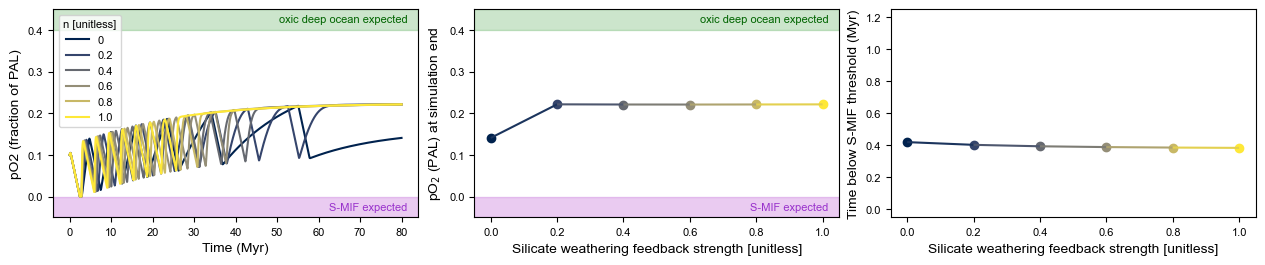

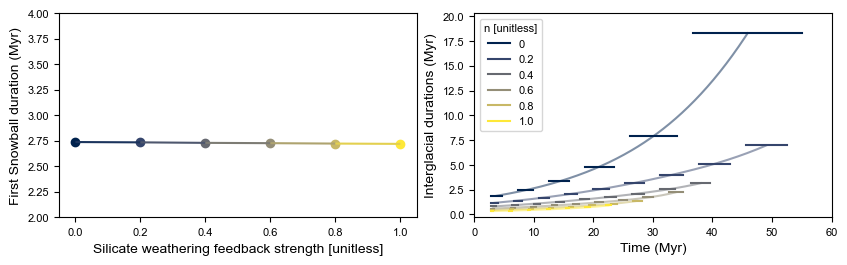

In [21]:
param_name = 'n'
param_values = [0,0.2,0.4,0.6,0.8,1.0]
highlight_vals = None
p, vals, results_all = run_analysis(param_name, param_values,default_params,
                                    highlight_vals=highlight_vals)

n_stored = [p, vals, results_all]

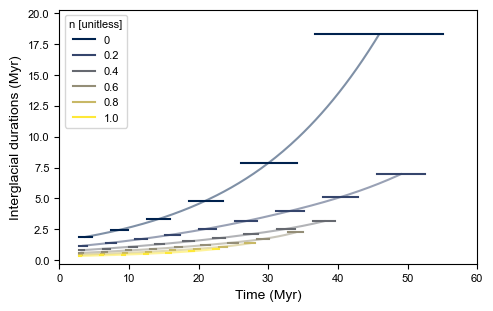

In [27]:
p, vals, results_all = n_stored

fig = plot_custom_grid(
    figname="indur_n.pdf",
    keys=["interglacial_durations"],
    #highlight_vals = [0.0,0.2,1.0],
    param_name=p,
    param_values=vals,
    results_all=results_all)
plt.show()

Running tau = 1


/Users/cminsky/Documents/Research/limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.33e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")


Running tau = 5
Running tau = 10
Running tau = 15
Running tau = 20
Running tau = 25
Running tau = 30


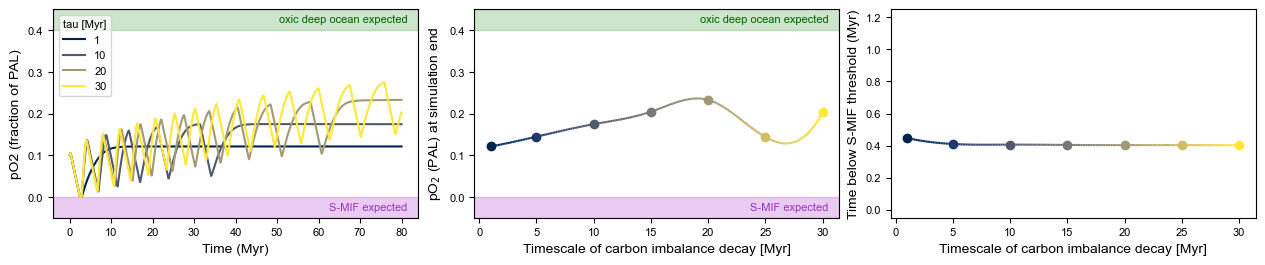

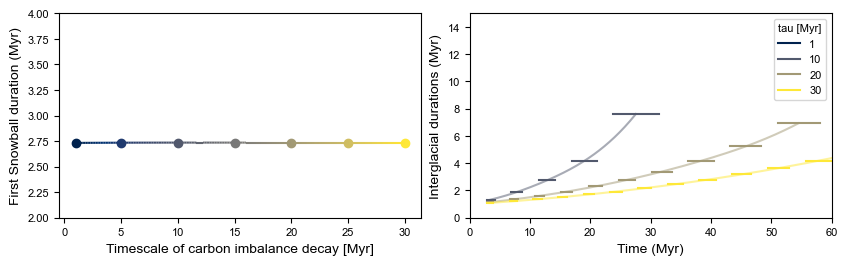

In [236]:
param_name = 'tau'
param_values = [1,5,10,15,20,25,30]
highlight_vals = [1,10,20,30]
p, vals, results_all = run_analysis(param_name, param_values,default_params,
                                    highlight_vals=highlight_vals)

tau_stored = p, vals, results_all

In [28]:
p, vals, results_all = tau_stored

fig = plot_custom_grid(
    figname="indur_tau.pdf",
    keys=["interglacial_durations"],
    highlight_vals = [1,5,10,15,20,25,30],
    param_name=p,
    param_values=vals,
    results_all=results_all)
plt.show()

NameError: name 'tau_stored' is not defined

## pO2

Running forg = 0.2
Running forg = 0.225
Running forg = 0.25
Running forg = 0.275


/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.33e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")


Running forg = 0.3
Running forg = 0.4


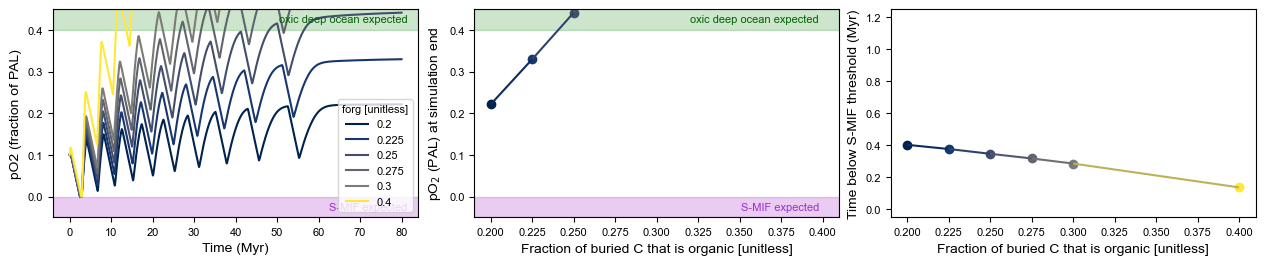

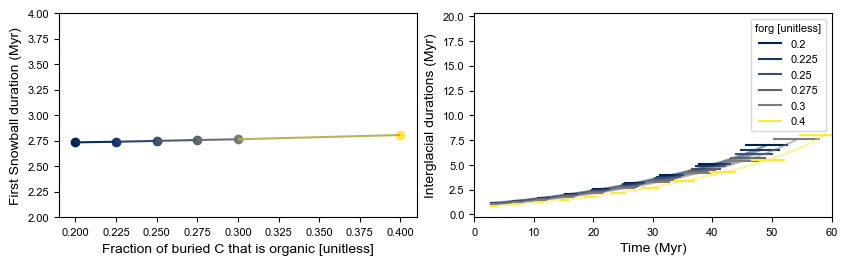

In [22]:
param_name = 'forg'
param_values = [0.2, 0.225, 0.25, 0.275, 0.3, 0.4]

highlight_vals = None
p, vals, results_all = run_analysis(param_name, param_values,default_params,
                                    highlight_vals=highlight_vals)

forg_stored = [p, vals, results_all]

Running nb = 1
Running nb = 1.25
Running nb = 1.5
Running nb = 1.75
Running nb = 2


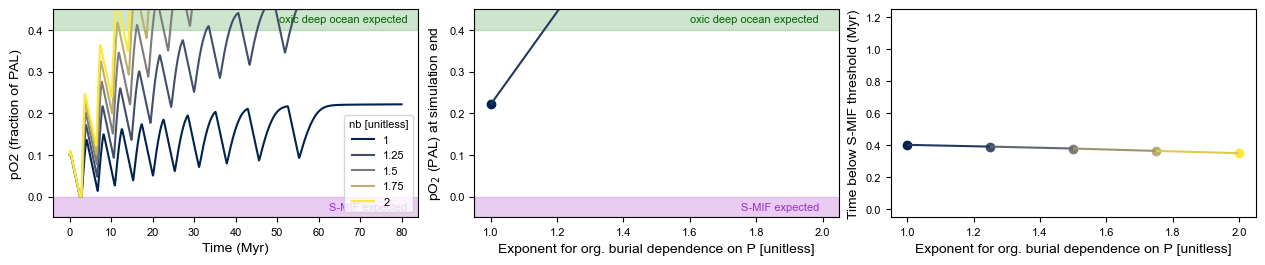

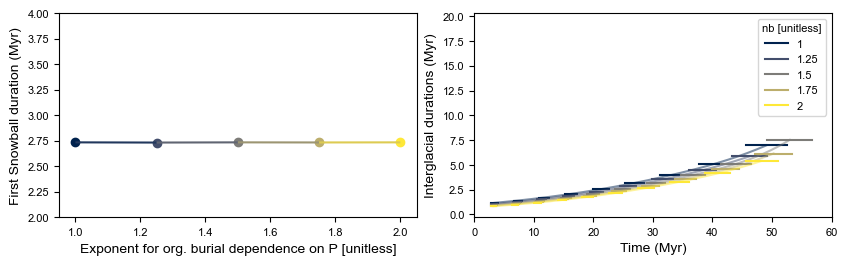

In [23]:
param_name = 'nb'
param_values = [1, 1.25, 1.5, 1.75, 2]
highlight_vals = None
p, vals, results_all = run_analysis(param_name, param_values,default_params,
                                    highlight_vals=highlight_vals)

nb_stored = [p, vals, results_all]

Running PC_LIP = 0.007
Running PC_LIP = 0.008
Running PC_LIP = 0.009
Running PC_LIP = 0.01
Running PC_LIP = 0.011


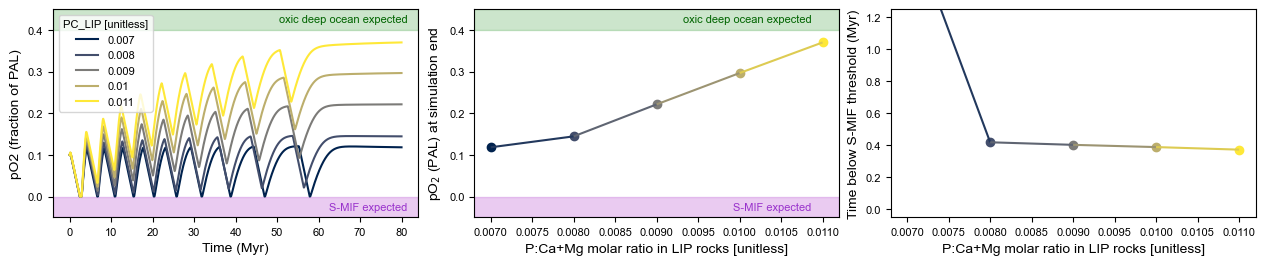

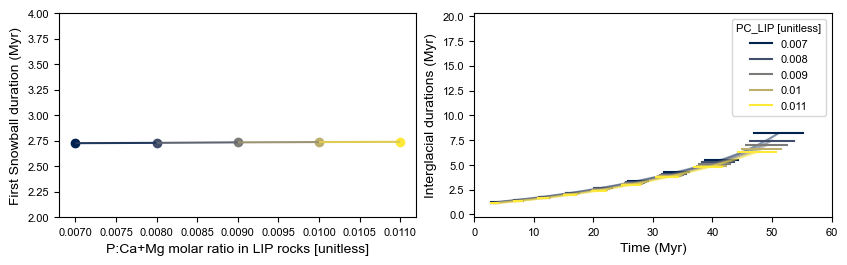

In [25]:
param_name = 'PC_LIP'
param_values = [0.007,0.008,0.009,0.010,0.011]
highlight_vals = None
p, vals, results_all = run_analysis(param_name, param_values,default_params,
                                    highlight_vals=highlight_vals)

PCLIP_stored = [p, vals, results_all]

Running W_sea = 0.0
Running W_sea = 0.6
Running W_sea = 1.2
Running W_sea = 1.8
Running W_sea = 2.4


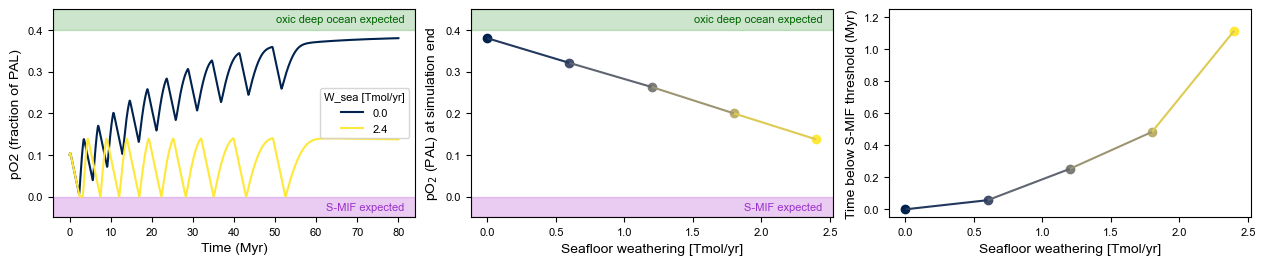

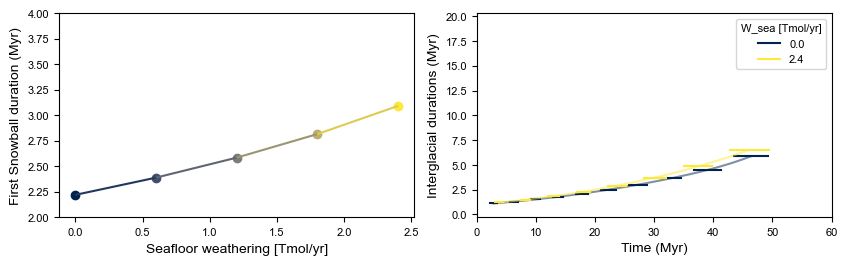

In [20]:
param_name = 'W_sea'
param_values = [0.0,0.6,1.2,1.8,2.4]
highlight_vals = [0.0,1.6,2.4]
p, vals, results_all = run_analysis(param_name, param_values,default_params,
                                    highlight_vals=highlight_vals)

Wsea_stored = [p, vals, results_all]

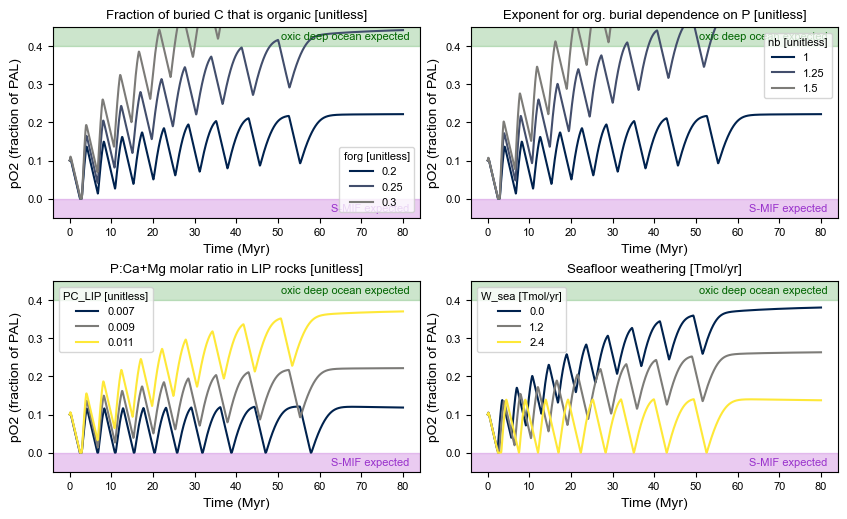

In [29]:
# unpack stored results
p_forg, vals_forg, results_forg = forg_stored
p_nb, vals_nb, results_nb = nb_stored
p_pclip, vals_pclip, results_pclip = PCLIP_stored
p_wsea, vals_wsea, results_wsea = Wsea_stored

# mke figure
fig, axs = plt.subplots(2, 2, figsize=(4.18 * 2, 2.54 * 2), constrained_layout=True)
axs = axs.ravel()

# Panel 1: forg
plot_pO2_multi_ax(axs[0], p_forg, vals_forg, results_forg,
                  cmap_name="cividis",
                  highlight_vals=[0.2, 0.25, 0.3],
                  t_max=80)
axs[0].set_title(get_param_label(p_forg))

# Panel 2: nb
plot_pO2_multi_ax(axs[1], p_nb, vals_nb, results_nb,
                  cmap_name="cividis",
                  highlight_vals=[1, 1.25, 1.5],
                  t_max=80)
axs[1].set_title(get_param_label(p_nb))

# Panel 3: PC_LIP
plot_pO2_multi_ax(axs[2], p_pclip, vals_pclip, results_pclip,
                  cmap_name="cividis",
                  highlight_vals=[0.007, 0.009, 0.011],
                  t_max=80)
axs[2].set_title(get_param_label(p_pclip))

# Panel 4: W_sea
plot_pO2_multi_ax(axs[3], p_wsea, vals_wsea, results_wsea,
                  cmap_name="cividis",
                  highlight_vals=[0.0, 1.2, 2.4],
                  t_max=80)
axs[3].set_title(get_param_label(p_wsea))

# Save or show
savefig(fig, "O2_panel.pdf", savefmt="pdf", supp_folder="supp")
plt.show()